## Задача кластеризации текстов.

Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

pd.set_option('display.max_colwidth', None)

Загрузим подготовленные данные. В столбце processed_text все тексты уже лемматизированы и затем дополнительно обработаны

In [2]:
df = pd.read_csv(r"D:\hackaton\hackaton\files\df_final_100k_more_then_10_words.csv") 

In [3]:
df.sample(1)

,public_url,post_url,post_text,cleaned_texts,processed_text
74329,https://vk.com/chelnynews_ru,https://vk.com/wall-54537775_1272507,"Челнинка выиграла чемпионат Европы по армспорту\n\nВ Болгарии завершились чемпионат и первенство Европы по армспорту. Среди девушек до 21 года в весовой категории до 55 кг чемпионкой стала спортсменка из Набережных Челнов, воспитанница ДЮСШ «Витязь» Миляуша Гимранова. Третье место в весовой категории до 55 кг занял еще один челнинец - Ирек Зиятдинов. \n\nВсего в соревнованиях приняли участие спортсмены из 30 стран.\n\nИсточник: chelny-izvest",челнинка выиграла чемпионат европы по армспорту в болгарии завершились чемпионат и первенство европы по армспорту среди девушек до года в весовой категории до кг чемпионкой стала спортсменка из набережных челнов воспитанница дюсш витязь миляуша гимранова третье место в весовой категории до кг занял еще один челнинец ирек зиятдинов всего в соревнованиях приняли участие спортсмены из стран источник,челнинка выиграть чемпионат европа армспорту болгария завершиться чемпионат первенство европа армспорту девушка год весовой категория чемпионка спортсменка набережный чёлн воспитанница дюсш витязь миляуша гимранова третий место весовой категория занять челнинец ирек зиятдинов соревнование принять участие спортсмен страна источник


Напишем функцию для вывода топ-слов в каждом кластере

In [4]:
def print_top_words(kmeans, terms, n_top_words):

    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    for i in range(kmeans.n_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i, :n_top_words]]
    
        print(f'Tема {i}: {", ".join(top_terms)}')

### Векторизуем тексты с помощью TfidfVectorizer. 

Так как данные достаточно шумные будем рассматривать униграммы, биграммы и убирать токен, если он встречается в более чем 85% текстов и встречается менее чем в 10-ти  текстах. Максимальное количество признаков - 10000

In [5]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.85,            
    min_df=10,               
    ngram_range=(1, 2),
    max_features=10000
)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

Перед отправкой в модель нормализуем данные

In [6]:
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_tfidf)

В планах обучать модель LDA и результаты её работы отдавать модели KMeans в качестве начальных центроид.

Для этого выполним подбор оптимального количества кластеров с помощью метода локтя. Будем перебирать количество кластеров от 25 до 35 включительно.

In [7]:
inertia_values = []

# перебор количества кластеров
for n_clusters in tqdm(range(25, 36), desc='Обработка кластеров'):
    # обучение LDA
    lda = LatentDirichletAllocation(n_components=n_clusters, random_state=42)
    lda.fit(X_normalized)

    # получение центроид
    lda_centroids = lda.components_

    # KMeans принимает нормализованные векторы
    # по этой причине будем нормализовать центроиды LDA
    lda_centroids = lda_centroids / lda_centroids.sum(axis=1)[:, np.newaxis]

    # обучение KMeans с центроидами от LDA
    kmeans = KMeans(n_clusters=n_clusters, init=lda_centroids, n_init=1, random_state=42)
    kmeans.fit(X_normalized)

    # добавляем значения инерции
    inertia_values.append(kmeans.inertia_)

Обработка кластеров:   0%|          | 0/11 [00:00<?, ?it/s]

Теперь построим график метода локтя для визуальной оценки оптимального числа кластеров

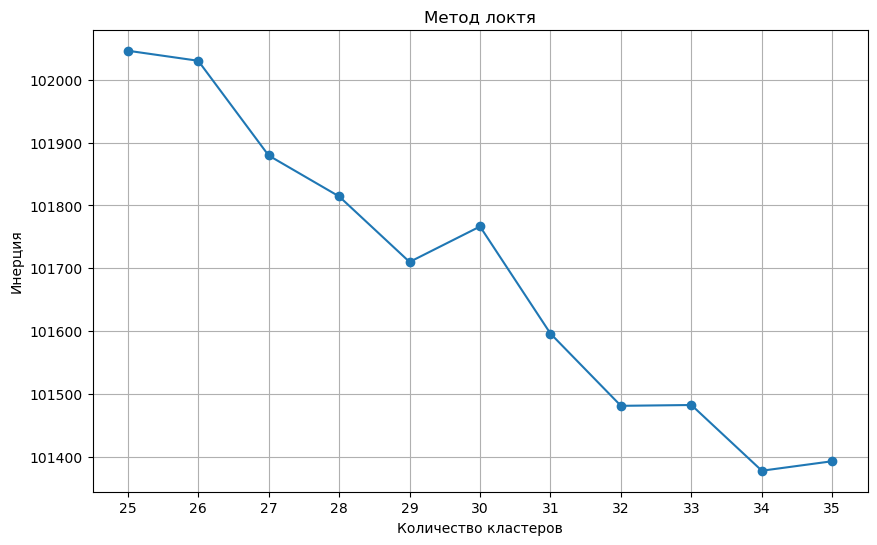

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(25, 36), inertia_values, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.xticks(range(25, 36))
plt.grid()
plt.show()

Из графика видно, что оптимальное число кластеров - 34

In [9]:
n_clusters = 34

In [10]:
lda = LatentDirichletAllocation(n_components=n_clusters, random_state=12345)
lda.fit(X_normalized)

lda_centroids = lda.components_

lda_centroids = lda_centroids / lda_centroids.sum(axis=1)[:, np.newaxis]

In [11]:
kmeans = KMeans(n_clusters=n_clusters, init=lda_centroids, n_init=1, random_state=12345)
kmeans.fit(X_normalized)

labels_kmeans = kmeans.labels_

terms = tfidf_vectorizer.get_feature_names_out()

In [36]:
print_top_words(kmeans, terms, 10)

Tема 0: пожар, мчс, пожарный, спасатель, возгорание, мужчина, огонь, дом, рыбак, район
Tема 1: россия, год, путин, российский, страна, президент, украина, депутат, владимир, заявить
Tема 2: ребёнок, родитель, детский, семья, год, сад, девочка, мама, мальчик, мать
Tема 3: водитель, гибдд, автомобиль, машина, дорога, движение, сотрудник гибдд, сотрудник, дорожный, штраф
Tема 4: год, новый, человек, время, казань, сегодня, слово, день, видео, первый
Tема 5: школа, ребёнок, класс, учитель, ученик, образование, учебный, родитель, год, школьник
Tема 6: пропасть, чёрный, местонахождение, помочь найти, пропажа, телосложение, примета, найти человек, местонахождение неизвестный, волос
Tема 7: мужчина, летний, полиция, задержать, женщина, полицейский, уголовный, сотрудник, чёлн, дело
Tема 8: матч, команда, клуб, игра, футбольный, лига, стадион, рубин, футбол, болельщик
Tема 9: мэр, магдеев, наиль, город, наиль магдеев, чёлн, набережный, мэр город, набережный чёлн, руководитель
Tема 10: конкурс, ф

In [37]:
topics = {
    0: "пожар",
    1: "политика",
    2: "семья",
    3: "дорожное движение",
    4: "социальные события, разное",
    5: "образование",
    6: "пропажа",
    7: "полиция и криминал",
    8: "футбол",
    9: "областная политика",
    10: "конкурсы и фестивали",
    11: "правосудие",
    12: "авария",
    13: "город",
    14: "транспорт",
    15: "парки и развлечения",
    16: "водоснабжение и ЖКХ",
    17: "медицинская помощь",
    18: "коронавирус",
    19: "жильё",
    20: "республика татарстан",
    21: "финансы",
    22: "ремонт",
    23: "общество",
    24: "проверка",
    25: "работа",
    26: "экономика",
    27: "животные",
    28: "погода",
    29: "авиация",
    30: "информация от граждан",
    31: "праздник",
    32: "спорт",
    33: "руководство"
}


In [38]:
df['cluster_label'] = kmeans.predict(X_normalized)

In [39]:
df['cluster_name'] = df['cluster_label'].map(topics)

## Полный цикл обработки и кластеризации

Модель, векторизатор и нормализатор можно загрузить из отдельных файлов с помощью joblib.load

In [46]:
import re
import spacy
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

# Загрузка модели русского языка для SpaCy
nlp = spacy.load("ru_core_news_sm")

def classify_text(text, tfidf_vectorizer, normalizer, kmeans_model):
    # Функция для очистки текста
    def clean_text(text):
        text = text.replace('\n', ' ')  
        text = re.sub(r'http\S+', '', text) 
        text = re.sub(r'www\.\S+', '', text)
        text = re.sub(r'\S+@\S+\.\S+', '', text) 
        text = re.sub(r'#\w+', '', text)
        text = re.sub('[^а-яА-ЯёЁ ]', ' ', text) 
        text = text.lower() 
        return text

    # Функция для лемматизации текста
    def lem_tok_text(text):
        if isinstance(text, str):
            doc = nlp(text)
            lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
            return ' '.join(lemmatized_tokens)
        else:
            return ''

    # Функция для фильтрации коротких слов
    def remove_short_words(text):
        return ' '.join([word for word in text.split() if len(word) >= 3])

    # Очистка и обработка текста
    cleaned_text = clean_text(text)
    processed_text = lem_tok_text(cleaned_text)
    processed_text = remove_short_words(processed_text)

    # Проверьте, достаточно ли слов в обработанном тексте
    if len(processed_text.split()) < 10:
        return "Недостаточно слов в тексте", "Неизвестная тема" 

    # Векторизация и нормализация
    tfidf_vector = tfidf_vectorizer.transform([processed_text])
    normalized_vector = normalizer.transform(tfidf_vector)

    # Кластеризация
    cluster = kmeans_model.predict(normalized_vector)[0]

    # Определение темы
    topics = {
        0: "пожар",
        1: "политика",
        2: "семья",
        3: "дорожное движение",
        4: "социальные события, разное",
        5: "образование",
        6: "пропажа",
        7: "полиция и криминал",
        8: "футбол",
        9: "областная политика",
        10: "конкурсы и фестивали",
        11: "правосудие",
        12: "авария",
        13: "город",
        14: "транспорт",
        15: "парки и развлечения",
        16: "водоснабжение и ЖКХ",
        17: "медицинская помощь",
        18: "коронавирус",
        19: "жильё",
        20: "республика татарстан",
        21: "финансы",
        22: "ремонт",
        23: "общество",
        24: "проверка",
        25: "работа",
        26: "экономика",
        27: "животные",
        28: "погода",
        29: "авиация",
        30: "информация от граждан",
        31: "праздник",
        32: "спорт",
        33: "руководство"
    }

    topic = topics.get(cluster, "Неизвестная тема")

    return f"Кластер: {cluster}", topic


In [48]:
text = '''Владелец компании «Еврокрона» Надир Краснов прокомментировал ситуацию вокруг объекта в 48-м микрорайоне Набережных Челнов. Конфликт между соседями в эти дни разгорается с новой силой. Жители, которые выступают против того, чтобы застройщик подключался к сетям их дома, сообщили, что к объекту вновь вызывали полицию. На прошлой неделе уже был подобный случай. Тогда полиция приехала по звонку застройщика.

- Жители соседнего дома занимаются вредительством - не дают выполнить работы, которые полностью согласованы, - рассказал Краснов. - Они ставили машины на колодцы сетей. Не давали доступ нам, поэтому полицию вызывали. Бойкотируют, мешают, на работников «Челныводоканала» нападают. Выходят со своими пикетами. Речь идет о подключении к сетям. Вся документация имеется, ордер на земельные работы открыт. У жителей же позиция – «не хотим, чтобы здесь что-то делали», и все. Подрядчиком является «Челныводоканал» - известная в городе компания. Протокол, который они сделали (ранее жители ссылались на документ, подписанный по итогам общего собрания, - ред.), не имеет никакой законной силы. Сети являются городскими. Они не имеют права препятствовать подключениям. Да, это их общедомовая территория, никто с этим не спорит. Да, сеть находится на их территории. Мы сейчас без разрушения дорожного полотна все это делаем. Они даже не увидят и не услышат.

Тем временем жители продолжают дежурить во дворе, охраняя свою придомовую территорию. По их словам, в ордерах, выписанных на земельные работы, указан адрес не их дома. Кроме того, ранее они передали своей УК «Строим будущее» протокол общего собрания, в котором большинство проголосовало против того, чтобы на общедомовой территории велись строительные работы. Горожане жалуются, что управляющая компания ситуацию проигнорировала.'''

cluster_message, topic = classify_text(text, tfidf_vectorizer, normalizer, kmeans)

print(cluster_message)
print("Тема:", topic)

Кластер: 19
Тема: жильё
